# **SentIA**


**🧠 Diario emocional para psicólogos**

  🌟 Valor diferencial:
  - Ayuda a psicólogos a visualizar la evolución emocional de un paciente entre sesiones.

  -   Sistema de alertas tempranas basado en emociones como "miedo", "tristeza", "ira".

  - *Potencial* de integrarse en apps de salud mental como journaling apps (ej: Daylio, Moodfit...).

  🔧 Técnica:
  - Entrenar modelo de clasificación emocional con este dataset (ya viene etiquetado).

  - Se puede hacer visualización temporal (tipo línea de tiempo con emociones).

  - Añadir reglas o thresholds para generar alertas (ej: 3 días seguidos con "miedo" o "tristeza" → alerta al terapeuta).

  🚀 Pitch fuerte:
  - “Ayudamos a psicólogos a prevenir crisis emocionales con IA que analiza el estado anímico diario de sus pacientes.”

  - Producto SaaS para psicólogos, fácil de integrar en sus sesiones.
____

Dataset:
https://www.kaggle.com/datasets/nelgiriyewithana/emotions

## **Validación de un modelo para la idea**


 Se pretende validar el concepto entrenando un dataset sin hacer apenas preprocesamiento

### Análisis exploratorio

In [ ]:
!pip install transformers datasets scikit-learn

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [29]:
#data_path = "/content/drive/MyDrive/Master AI & Big Data/09 Tecnicas Avanzadas de IA/NLP/Practica Final NLP - SentIA/data/"
#model_path = "/content/drive/MyDrive/Master AI & Big Data/09 Tecnicas Avanzadas de IA/NLP/Practica Final NLP - SentIA/models/"

data_path = "data/"
model_path = "model/" #ruta para guardar el modelo de prueba, no el de "produccion" (app)

Valores faltantes por columna:
 Unnamed: 0    0
text          0
label         0
dtype: int64

Porcentaje de valores faltantes por columna:
 Unnamed: 0    0.0
text          0.0
label         0.0
dtype: float64

Distribución de categorías:
 label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


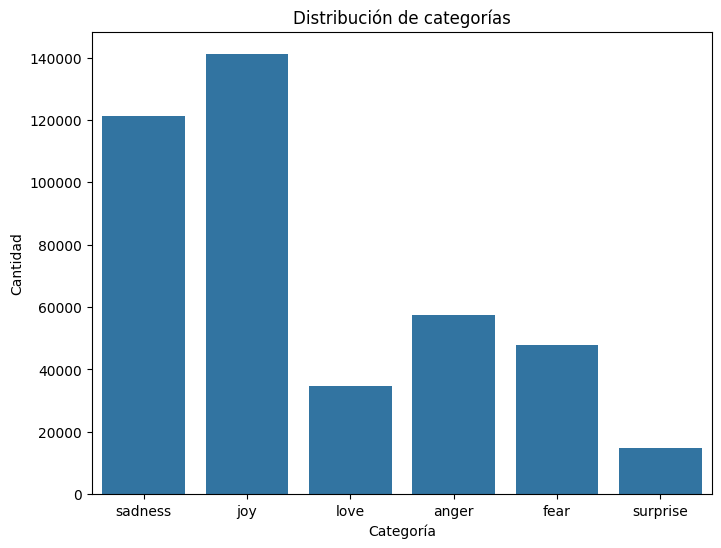

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


,Unnamed: 0,label
count,416809.000000,416809.000000
mean,208404.000000,1.554271
std,120322.538513,1.490453
min,0.000000,0.000000
25%,104202.000000,0.000000
50%,208404.000000,1.000000
75%,312606.000000,3.000000
max,416808.000000,5.000000


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carga el archivo CSV
df = pd.read_csv(data_path + 'text.csv')

# 1. Análisis de valores faltantes

# Imprime la cantidad de valores faltantes por columna
print("Valores faltantes por columna:\n", df.isnull().sum())

# Imprime el porcentaje de valores faltantes por columna
print("\nPorcentaje de valores faltantes por columna:\n", (df.isnull().sum() / len(df)) * 100)

# 2. Distribución de categorías:

# Imprime la cantidad de observaciones por categoría
print("\nDistribución de categorías:\n", df['label'].value_counts())

# Crea un gráfico de barras para visualizar la distribución de categorías
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribución de categorías')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(range(6), ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])  # Etiquetas personalizadas
plt.show()

df.info()
df.describe()

### Balanceo de clases

Las clases estan desbalanceadas y en este caso vamos a hacer undersampling

In [31]:

# Define la cantidad de datos a mantener para cada categoría (igual a la categoría con menos datos)
n_samples = df['label'].value_counts().min()  # Número de muestras de la categoría con menos datos

# Crea un nuevo DataFrame vacío para almacenar los datos balanceados
balanced_df = pd.DataFrame()

# Itera sobre cada categoría y selecciona n_samples aleatorios
for label in df['label'].unique():
    label_df = df[df['label'] == label].sample(n=n_samples, random_state=42)  # Selecciona n_samples aleatorios
    balanced_df = pd.concat([balanced_df, label_df])  # Concatena al DataFrame balanceado

# Ahora balanced_df contiene el dataset con las categorías niveladas

# Verifica la distribución de las categorías en el dataset balanceado
print(balanced_df['label'].value_counts())

# Guarda el dataset balanceado en un nuevo archivo CSV
balanced_df.to_csv(data_path + 'text_balanced.csv', index=False)

label
4    14972
0    14972
2    14972
1    14972
5    14972
3    14972
Name: count, dtype: int64


### Dividir los datasets

In [32]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

df = balanced_df

# Reduce the dataset to 1/10th of its size
reduced_df = df.sample(frac=0.1, random_state=42)  

# Preparar los datos
X = reduced_df['text']
y = reduced_df['label']

# 1. Dividimos en train + (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Dividimos (test + validation) en test y validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tratamos valores NaN en y_train, y_test, and y_val antes de continuar
# Eliminamos los valores nulos con drop

y_train = y_train.dropna()
y_test = y_test.dropna()
y_val = y_val.dropna()

# Filtramos X_train, X_test, and X_val por los datos sin valores nulos
X_train = X_train[y_train.index]
X_test = X_test[y_test.index]
X_val = X_val[y_val.index]

# OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto', handle_unknown='ignore')  # sparse=False for dense output, handle_unknown='ignore' to avoid errors during prediction

y_train_np = y_train.to_numpy()  # Convert to NumPy array
y_test_np = y_test.to_numpy()
y_val_np = y_val.to_numpy()

# Fit on training data and transform
y_train_encoded = encoder.fit_transform(y_train_np.reshape(-1, 1))  # Reshape NumPy array
y_test_encoded = encoder.transform(y_test_np.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val_np.reshape(-1, 1))

# Update your Datasets
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train_encoded.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test_encoded.tolist()})
val_dataset = Dataset.from_dict({"text": X_val.tolist(), "label": y_val_encoded.tolist()})

# Save datasets to CSV files
train_dataset.to_csv(data_path+'PoC_train_dataset.csv', index=False)
test_dataset.to_csv(data_path+'PoC_test_dataset.csv', index=False)
val_dataset.to_csv(data_path+'PoC_val_dataset.csv', index=False)

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 44.24ba/s]


106867

Comprobamos la distribucion de las clases para el conjunto de train:

label
[0. 0. 0. 0. 0. 1.]    1259
[0. 0. 1. 0. 0. 0.]    1255
[0. 0. 0. 0. 1. 0.]    1190
[0. 1. 0. 0. 0. 0.]    1184
[1. 0. 0. 0. 0. 0.]    1181
[0. 0. 0. 1. 0. 0.]    1117
Name: count, dtype: int64


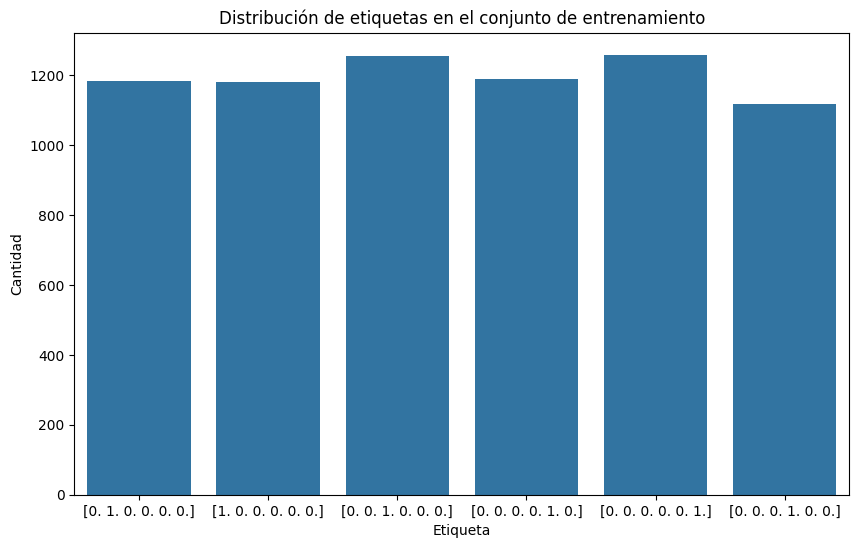

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_dataset = pd.read_csv(data_path + 'PoC_train_dataset.csv')

# Distribución numérica
print(train_dataset['label'].value_counts())

# Distribución gráfica
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_dataset)
plt.title('Distribución de etiquetas en el conjunto de entrenamiento')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad')
plt.show()

### Tokenizador

In [34]:
# Define model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)  # 6 labels (0-5)

# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Load datasets from CSV files
# This is the change to load the data correctly
train_dataset = pd.read_csv(data_path+'PoC_train_dataset.csv')
test_dataset = pd.read_csv(data_path+'PoC_test_dataset.csv')
val_dataset = pd.read_csv(data_path+'PoC_val_dataset.csv')

# Convert the 'label' column to lists of floats, handling spaces and extra periods
train_dataset['label'] = train_dataset['label'].apply(lambda x: [float(i) for i in x[1:-1].split() if i])  
test_dataset['label'] = test_dataset['label'].apply(lambda x: [float(i) for i in x[1:-1].split() if i])
val_dataset['label'] = val_dataset['label'].apply(lambda x: [float(i) for i in x[1:-1].split() if i])

# Convert the Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)  # Tokenize validation set

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 899/899 [00:00<00:00, 9043.16 examples/s]


### Entrenar modelo

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np


# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

# Train the model
trainer.train()

model_path = "/content/drive/MyDrive/Master AI & Big Data/09 Tecnicas Avanzadas de IA/NLP/Practica Final NLP - CortexCX/models/"
# Save the fine-tuned model
trainer.save_model(model_path)
# Save the tokenizer
tokenizer.save_pretrained(model_path)

# Evaluate on test set
predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy}")

Epoch,Training Loss,Validation Loss
1,No log,0.117243
2,0.270100,0.081046
3,0.083600,0.074595


Test Accuracy: 0.9376391982182628


### Funcion para determinar las emociones

In [27]:
def predict_probs(text, model_path=model_path, model_name=model_name):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=-1).detach().cpu().numpy()[0]

    # Emotion labels
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]

    # Print probabilities as percentages
    for i, emotion in enumerate(emotions):
        print(f"{emotion}: {probs[i] * 100:.2f}%")

    return probs

### Algunos ejemplos de uso:

In [ ]:
text = "I want to kiss you!"
emotion = predict_probs(text)

sadness: 0.49%
joy: 9.16%
love: 76.81%
anger: 11.49%
fear: 1.60%
surprise: 0.44%


In [ ]:
text = "I didn't expect my amazing birthday party!"
emotion = predict_probs(text)

sadness: 0.72%
joy: 7.13%
love: 0.36%
anger: 0.37%
fear: 0.80%
surprise: 90.63%


In [ ]:

text = "Pucela is going to be relegated to second division"
emotion = predict_probs(text)

sadness: 98.08%
joy: 0.17%
love: 0.12%
anger: 1.14%
fear: 0.38%
surprise: 0.11%


## **Modelo final**

Ahora que hemos visto de manera sencilla que el modelo funciona y es factible vamos a mejorar el procesamiento y el modelo

1. Análisis exploratorio:

  -  Hemos visto que no había missings
  
  - Hemos visto la distribución y hemos corregido el desbalanceo de clases.
  
  - Tenemos que revisar:

      -  Longitud media de los textos.

      - Wordcloud por emoción.

2. Preprocesado

  - Limpieza básica (lowercase, quitar puntuación, etc.)

  - Tokenizer de modelo preentrenado (Hugging Face).

3. Entrenamiento del modelo

  - DistilBERT con transformers


Métricas: accuracy, f1-score, confusion matrix

### Ampliación del análisis exploratorio

In [13]:
#Longitud media de los textos
df = pd.read_csv(data_path + 'text_balanced.csv')
df["length"] = df["text"].apply(lambda x: len(x.split()))
print(f"Longitud media: {df['length'].mean():.2f} palabras")
print(f"tamalño del dataset: {len(df)}")


Longitud media: 19.42 palabras
tamalño del dataset: 89832


In [6]:
df.head()

,Unnamed: 0,text,label,length
0,63426,i feel that it creates a suspicious environmen...,4,23
1,123419,i feel reluctant asking for anything,4,6
2,152597,i am afraid to really show what i feel because...,4,20
3,314008,i think he feels a little helpless in all this...,4,17
4,326501,i certainly feel tortured,4,4


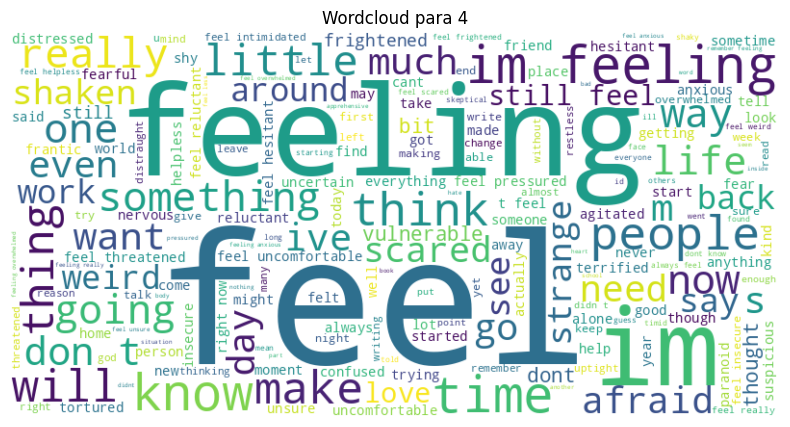

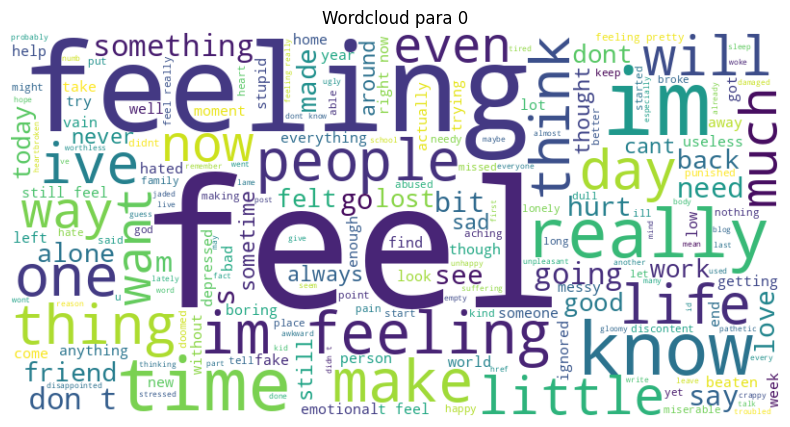

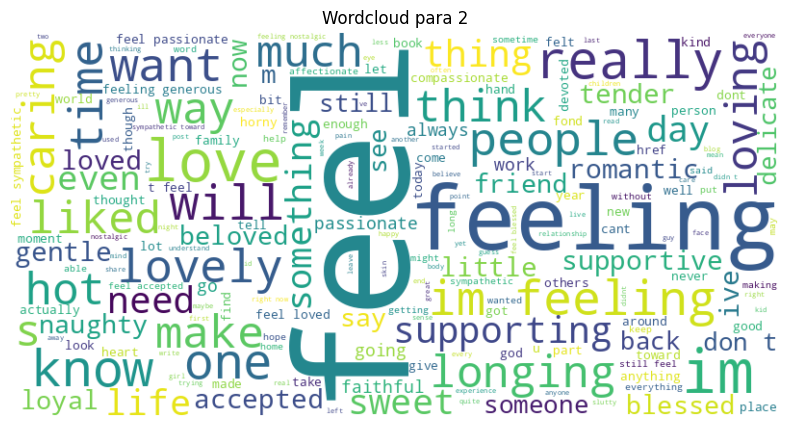

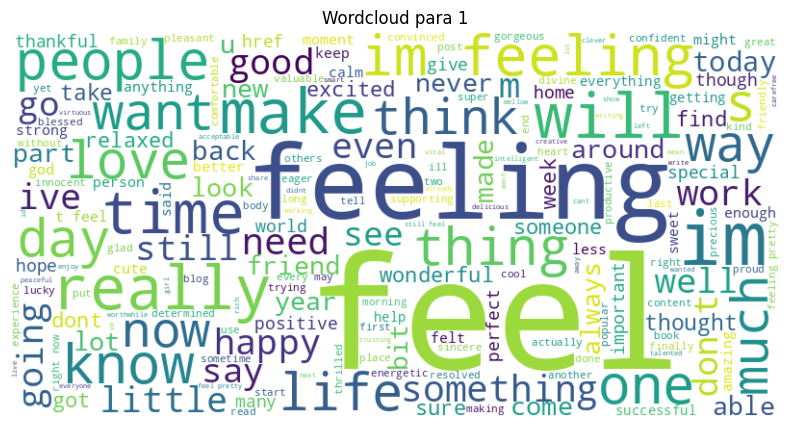

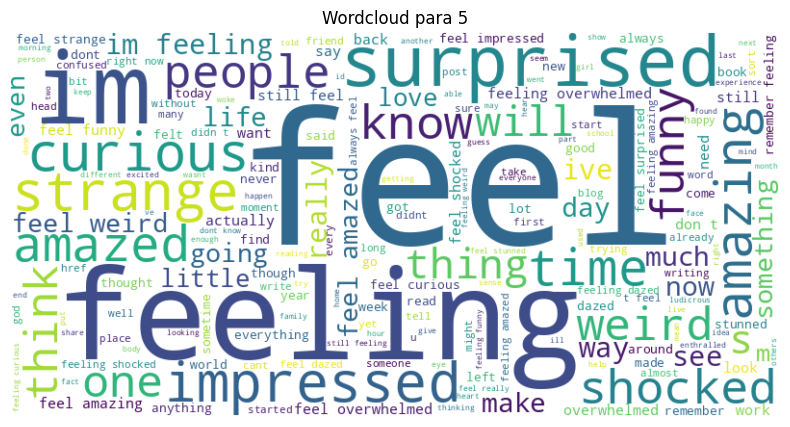

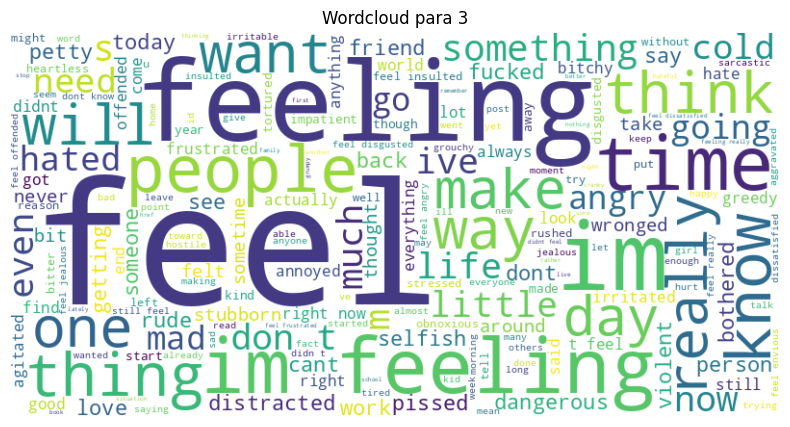

In [12]:
#Wordcloud por emocion
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in df["label"].unique():
    text = " ".join(df[df["label"] == label]["text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud para {label}")
    plt.show()


Vemos que hay palabras como feel, feeling que son muy generalistas, en el futuro se debería probar a entrenar el modelo eliminando estas palabras

### Preprocesado

In [7]:
#limpieza basica
import string

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

df["text"] = df["text"].apply(clean_text)

In [8]:
df.head()

,Unnamed: 0,text,label,length
0,63426,i feel that it creates a suspicious environmen...,4,23
1,123419,i feel reluctant asking for anything,4,6
2,152597,i am afraid to really show what i feel because...,4,20
3,314008,i think he feels a little helpless in all this...,4,17
4,326501,i certainly feel tortured,4,4


In [12]:
# Reduce the dataset to half its size.

half_size = len(df) // 2
reduced_df = df.sample(n=half_size, random_state=42) # Use random_state for reproducibility
reduced_df.to_csv(data_path + 'text_reduced.csv', index=False)
# printeo tamaño
print(f"Tamaño del dataset reducido: {len(reduced_df)}")

Tamaño del dataset reducido: 44916


Tokenizacion con AutoTokenizer

In [14]:
from transformers import AutoTokenizer

# Cargar el tokenizer correspondiente al modelo
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Función de tokenización
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preparacion de los datos con datasests de Hugging Face

In [15]:
from datasets import Dataset

dataset = Dataset.from_pandas(reduced_df) #metemos el reducido porque si no tardan mucho en entrenar

# Aplicar tokenización al dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 44916/44916 [00:03<00:00, 12061.91 examples/s]


Dividimos el dataset en train, val y test

In [16]:
from datasets import DatasetDict

# --- Reduce the dataset before splitting ---
#reduced_dataset = tokenized_dataset.select(range(len(tokenized_dataset) // 2))  # Select the first half

# 1. División en train + (val + test)
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# 2. División (val + test) en test y val
test_val_split = split_dataset["test"].train_test_split(test_size=0.5, seed=42)

# 3. Asignar conjuntos
train_dataset = split_dataset["train"]
val_dataset = test_val_split["test"]
test_dataset = test_val_split["train"]

# 4. Guardar versiones limpias para CSV (solo text + label)
train_dataset.to_pandas()[["text", "label"]].to_csv(data_path+"train_dataset.csv", index=False)
val_dataset.to_pandas()[["text", "label"]].to_csv(data_path+"val_dataset.csv", index=False)
test_dataset.to_pandas()[["text", "label"]].to_csv(data_path+"test_dataset.csv", index=False)

# printear el tamaño de los datasets

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 35932
Validation dataset size: 4492
Test dataset size: 4492


### Entrenamiento del modelo

In [17]:
#importamos librerias
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoTokenizer,
)
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np


Cargamos el modelo para clasificación

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(tokenized_dataset["label"]))  # número de clases
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
#definimos las metricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }


#argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    #fp16=True,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"  # evita problemas si no usamos wandb
)

#entrenamos con trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


#Evaluamos el conjunto de test
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
print(classification_report(test_dataset["label"], preds))


/var/folders/yh/8dr11nzd5nx2wzw16251t8b40000gn/T/ipykernel_44600/3536729319.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.200100,0.167087,0.942119,0.941217,0.941631
2,0.141800,0.151218,0.945013,0.944394,0.944717
3,0.109500,0.154075,0.946349,0.945821,0.946153


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       763
           1       0.99      0.91      0.95       718
           2       0.94      0.99      0.97       751
           3       0.97      0.94      0.96       726
           4       0.93      0.92      0.93       731
           5       0.93      1.00      0.96       803

    accuracy                           0.96      4492
   macro avg       0.96      0.95      0.96      4492
weighted avg       0.96      0.96      0.96      4492



El modelo entrenado con DistilBERT ha alcanzado un F1-score macro de 0.96 y una accuracy del 96% sobre el conjunto de test, mostrando un rendimiento sólido y equilibrado en todas las clases de emoción. Este rendimiento demuestra que el sistema es apto para un entorno productivo, como es el caso de nuestra app de diario

Guardamos el modelo

In [ ]:
model_path_app = "models" # directorio donde se guardará el modelo para la app

# Guardar modelo entrenado para usarlo en la app
model.save_pretrained(model_path_app)

# Guardar tokenizer
tokenizer.save_pretrained(model_path_app)

('models/tokenizer_config.json',
 'models/special_tokens_map.json',
 'models/vocab.txt',
 'models/added_tokens.json',
 'models/tokenizer.json')